In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import pandas as pd
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Insurance Claims/Insurance claims data.csv")
df.head()

,policy_id,subscription_length,vehicle_age,customer_age,region_code,region_density,segment,model,fuel_type,max_torque,...,is_brake_assist,is_power_door_locks,is_central_locking,is_power_steering,is_driver_seat_height_adjustable,is_day_night_rear_view_mirror,is_ecw,is_speed_alert,ncap_rating,claim_status
0,POL045360,9.3,1.2,41,C8,8794,C2,M4,Diesel,250Nm@2750rpm,...,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,3,0
1,POL016745,8.2,1.8,35,C2,27003,C1,M9,Diesel,200Nm@1750rpm,...,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,4,0
2,POL007194,9.5,0.2,44,C8,8794,C2,M4,Diesel,250Nm@2750rpm,...,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,3,0
3,POL018146,5.2,0.4,44,C10,73430,A,M1,CNG,60Nm@3500rpm,...,No,No,No,Yes,No,No,No,Yes,0,0
4,POL049011,10.1,1.0,56,C13,5410,B2,M5,Diesel,200Nm@3000rpm,...,No,Yes,Yes,Yes,No,No,Yes,Yes,5,0


In [4]:
# To start, we review the shape, check duplicates, data types, cardinality and null/missing values
print('Dataframe Shape:', df.shape, '\n')
print('Duplicates Count:  ', df.duplicated().sum(), '\n')

# Formatting for table
column_width_header = 40
column_width = 12

print(f"{'FEATURE' :<{column_width_header}} {'DATA TYPE':<{column_width}} {'CARDINALITY':>{column_width}}  {'MISSING VALUES':>{column_width}} \n")
for col in df.columns:
    print(f"{col :<{column_width_header}} {str(df[col].dtype):<{column_width}} {df[col].nunique(dropna=False):>{column_width}}  {df[col].isnull().sum():>{column_width}}")


Dataframe Shape: (58592, 41) 

Duplicates Count:   0 

FEATURE                                  DATA TYPE     CARDINALITY  MISSING VALUES 

policy_id                                object              58592             0
subscription_length                      float64               140             0
vehicle_age                              float64                49             0
customer_age                             int64                  41             0
region_code                              object                 22             0
region_density                           int64                  22             0
segment                                  object                  6             0
model                                    object                 11             0
fuel_type                                object                  3             0
max_torque                               object                  9             0
max_power                                object   

<function matplotlib.pyplot.show(close=None, block=None)>

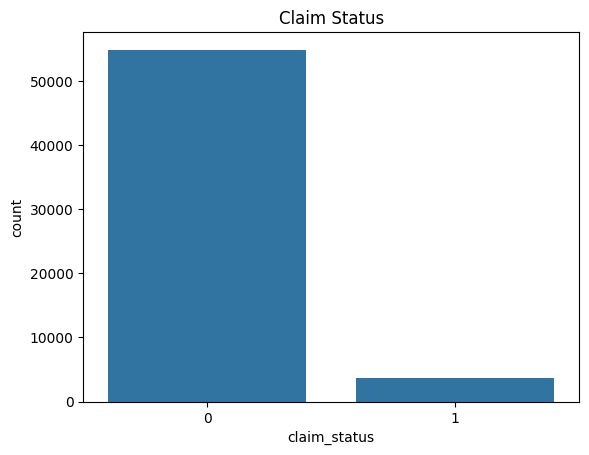

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.countplot(x = 'claim_status', data = df)
plt.title('Claim Status')
plt.show

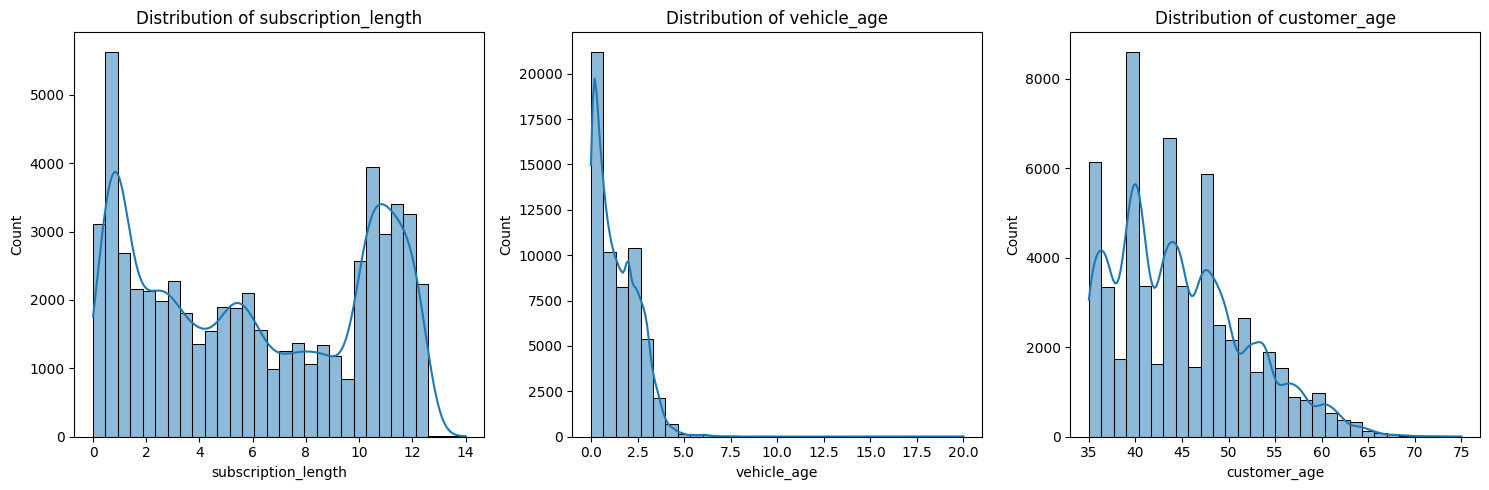

In [6]:
# selecting numerical columns for analysis
numerical_columns = ['subscription_length', 'vehicle_age', 'customer_age']

# plotting distributions of numerical features
plt.figure(figsize=(15, 5))
for i, column in enumerate(numerical_columns, 1):
    plt.subplot(1, 3, i)
    sns.histplot(df[column], bins=30, kde=True)
    plt.title(f'Distribution of {column}')

plt.tight_layout()
plt.show()

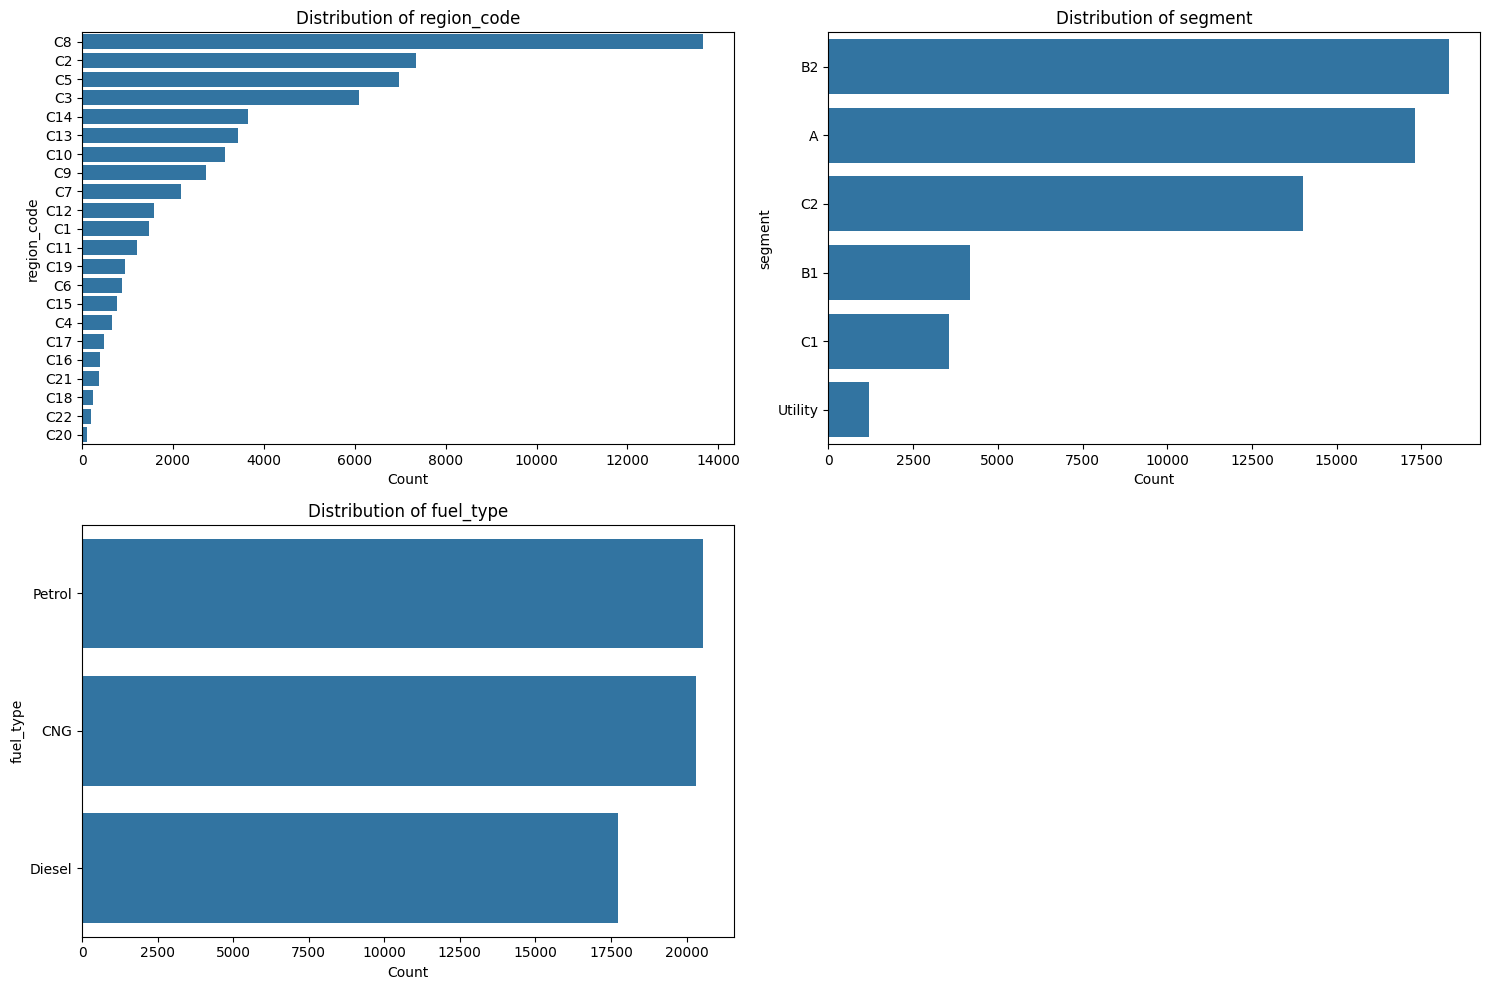

In [7]:
# selecting some relevant categorical columns for analysis
categorical_columns = ['region_code', 'segment', 'fuel_type']

# plotting distributions of categorical features
plt.figure(figsize=(15, 10))
for i, column in enumerate(categorical_columns, 1):
    plt.subplot(2, 2, i)
    sns.countplot(y=column, data=df, order = df[column].value_counts().index)
    plt.title(f'Distribution of {column}')
    plt.xlabel('Count')
    plt.ylabel(column)

plt.tight_layout()
plt.show()

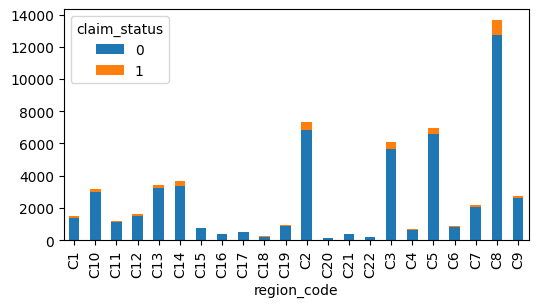

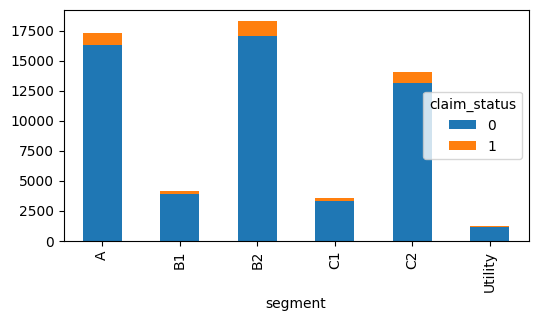

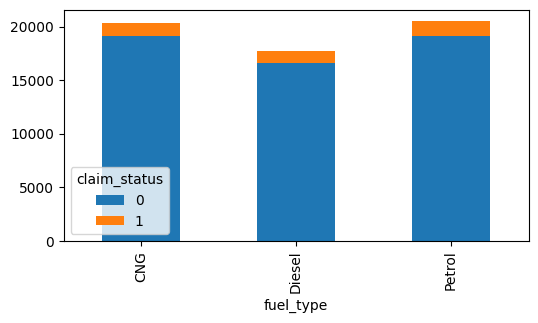

In [16]:
for col in categorical_columns:
    cross_tab = pd.crosstab(df[col], df['claim_status'])
    cross_tab.plot(kind='bar', stacked=True, figsize=(6,3))
    plt.show()


In [9]:
from sklearn.utils import resample

# separate majority and minority classes
majority = df[df.claim_status == 0]
minority = df[df.claim_status == 1]

# oversample the minority class
minority_oversampled = resample(minority,
                                replace=True,
                                n_samples=len(majority),
                                random_state=42)

# combine majority class with oversampled minority class
oversampled_data = pd.concat([majority, minority_oversampled])

# check the distribution of undersampled and oversampled datasets
oversampled_distribution = oversampled_data.claim_status.value_counts()

oversampled_distribution

,count
claim_status,
0,54844
1,54844


<function matplotlib.pyplot.show(close=None, block=None)>

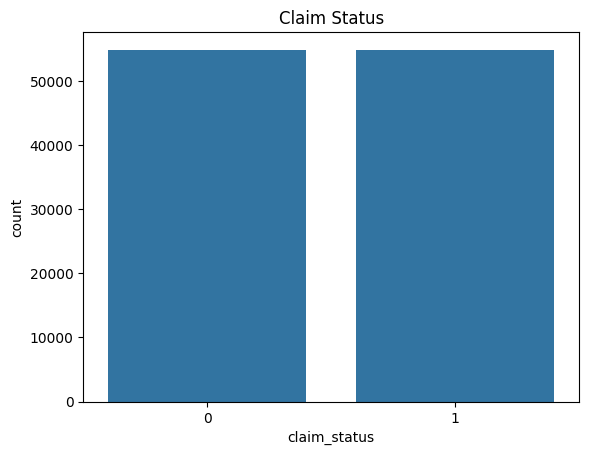

In [17]:
sns.countplot(x = 'claim_status', data = oversampled_data)
plt.title('Claim Status')
plt.show

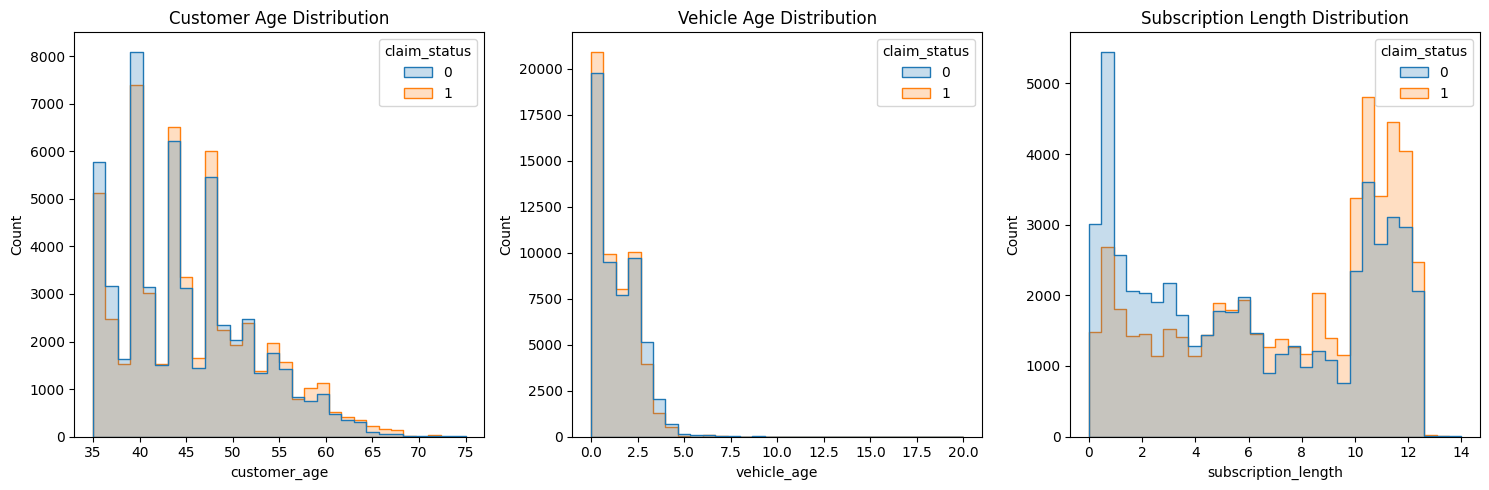

In [10]:
# plotting the distribution of 'customer_age', 'vehicle_age', and 'subscription_length' with respect to 'claim_status'
plt.figure(figsize=(15, 5))

# 'customer_age' distribution
plt.subplot(1, 3, 1)
sns.histplot(data=oversampled_data, x='customer_age', hue='claim_status', element='step', bins=30)
plt.title('Customer Age Distribution')

# 'vehicle_age' distribution
plt.subplot(1, 3, 2)
sns.histplot(data=oversampled_data, x='vehicle_age', hue='claim_status', element='step', bins=30)
plt.title('Vehicle Age Distribution')

# 'subscription_length' distribution
plt.subplot(1, 3, 3)
sns.histplot(data=oversampled_data, x='subscription_length', hue='claim_status', element='step', bins=30)
plt.title('Subscription Length Distribution')

plt.tight_layout()
plt.show()

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

# encode categorical variables
le = LabelEncoder()
encoded_data = df.apply(lambda col: le.fit_transform(col) if col.dtype == 'object' else col)

# separate features and target variable
X = encoded_data.drop('claim_status', axis=1)
y = encoded_data['claim_status']

# create a random forest classifier model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X, y)

# get feature importance
feature_importance = rf_model.feature_importances_

# create a dataframe for visualization of feature importance
features_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importance})
features_df = features_df.sort_values(by='Importance', ascending=False)

print(features_df.head(10))  # displaying the top 10 important features

                Feature  Importance
0             policy_id    0.321072
1   subscription_length    0.248309
3          customer_age    0.176639
2           vehicle_age    0.135190
5        region_density    0.053838
4           region_code    0.052649
7                 model    0.000957
24               length    0.000846
26         gross_weight    0.000834
11          engine_type    0.000791


In [12]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier

# drop 'Policy_id' column from the data
oversampled_data = oversampled_data.drop('policy_id', axis=1)

# prepare the oversampled data
X_oversampled = oversampled_data.drop('claim_status', axis=1)
y_oversampled = oversampled_data['claim_status']

# encoding categorical columns
X_oversampled_encoded = X_oversampled.apply(lambda col: LabelEncoder().fit_transform(col) if col.dtype == 'object' else col)

# splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_oversampled_encoded, y_oversampled, test_size=0.3, random_state=42)

# create and train the Random Forest model
rf_model_oversampled = RandomForestClassifier(random_state=42)
rf_model_oversampled.fit(X_train, y_train)

# predictions
y_pred = rf_model_oversampled.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.96      0.98     16574
           1       0.96      1.00      0.98     16333

    accuracy                           0.98     32907
   macro avg       0.98      0.98      0.98     32907
weighted avg       0.98      0.98      0.98     32907



In [13]:
original_encoded = df.drop('policy_id', axis=1).copy()
encoders = {col: LabelEncoder().fit(X_oversampled[col]) for col in X_oversampled.select_dtypes(include=['object']).columns}

for col in original_encoded.select_dtypes(include=['object']).columns:
    if col in encoders:
        original_encoded[col] = encoders[col].transform(original_encoded[col])

original_encoded_predictions = rf_model_oversampled.predict(original_encoded.drop('claim_status', axis=1))

comparison_df = pd.DataFrame({
    'Actual': original_encoded['claim_status'],
    'Predicted': original_encoded_predictions
})

print(comparison_df.head(10))

   Actual  Predicted
0       0          0
1       0          0
2       0          0
3       0          1
4       0          0
5       0          0
6       0          0
7       0          0
8       0          0
9       0          0


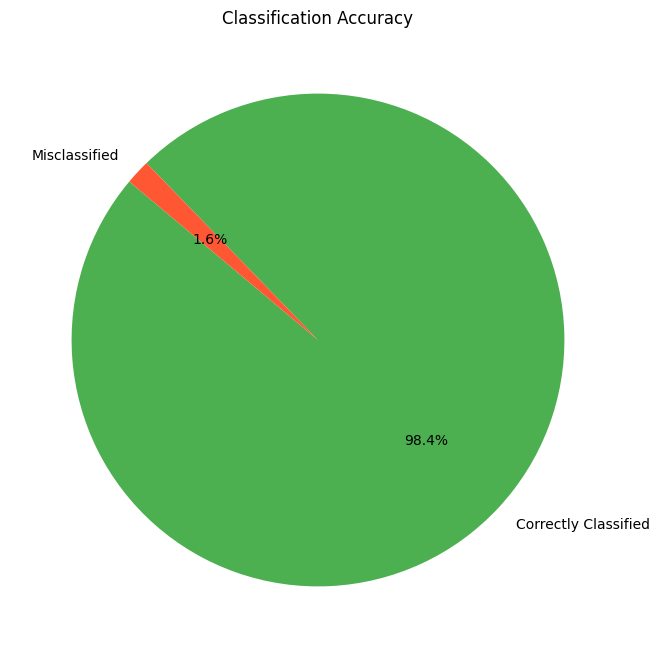

In [14]:
correctly_classified = (comparison_df['Actual'] == comparison_df['Predicted']).sum()
incorrectly_classified = (comparison_df['Actual'] != comparison_df['Predicted']).sum()

classification_counts = [correctly_classified, incorrectly_classified]
labels = ['Correctly Classified', 'Misclassified']

# create a pie chart
plt.figure(figsize=(8, 8))
plt.pie(classification_counts, labels=labels, autopct='%1.1f%%', startangle=140, colors=['#4CAF50', '#FF5733'])
plt.title('Classification Accuracy')
plt.show()